In [0]:
#Given a map consisting of known poses and a start and end pose, find the optimal path between using A*
#Generate the relative motion in se2 between poses.
#This is straight line motion.
#Also implements cubic interpolation for a smooth trajectory across all points in path.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.interpolate
import heapq #https://docs.python.org/3/library/heapq.html

In [0]:
#Loading poses from the ground truth file
def load_poses(pose_gt_file) :
    pose_gt = np.loadtxt(pose_gt_file, delimiter = ",")
    return pose_gt[1:, 1:3]

poses = load_poses('../dataset/data/ground_truth/groundtruth_2012-01-08.csv')

In [0]:
#Astar and path functions
class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

class Astar :
  # This class implements A* search along a network defined by several points
  # Poses is an array of coordinates
  # k defines how many nearest neighbors to look at during A* search
  # The primary usage of this class is the find_path function:
  #   Required parameters:
  #     start_idx:  
  #     goal_idx    

  def __init__(self, poses) :
    self.poses = poses
    self.full_tree = scipy.spatial.KDTree(self.poses)

  def _extract_path(self, cur_node, parent_idx, start_idx, sparse_poses):
    next_idx = cur_node
    path = [self.full_tree.query(sparse_poses[next_idx])[1]]

    while next_idx != start_idx:
      next_idx = parent_idx[next_idx]
      path.append(self.full_tree.query(sparse_poses[next_idx])[1])
    
    return path[::-1]

  def find_path(self, full_start_idx, full_goal_idx, sparseness=1, k=5):
    sparse_poses = poses[0::sparseness, :]
    
    visit_queue = PriorityQueue()
    visited_flag, queueed_flag = np.zeros(sparse_poses.shape[0]), np.zeros(sparse_poses.shape[0])
    g_score, h_score = np.full(sparse_poses.shape[0], np.inf), np.full(sparse_poses.shape[0], np.inf)
    parent_idx = np.zeros(sparse_poses.shape[0], dtype='int')

    sparse_tree = scipy.spatial.KDTree(sparse_poses)

    start_idx = sparse_tree.query(poses[full_start_idx])[1]
    goal_idx = sparse_tree.query(poses[full_goal_idx])[1]
   
    # initialize
    goal = sparse_poses[goal_idx]

    g_score[start_idx] = 0
    visit_queue.put(start_idx, np.inf)
    queueed_flag[start_idx] = 1
    optimal = False

    while not visit_queue.empty():
      cur_node = visit_queue.get()
      visited_flag[cur_node] = 1

      if cur_node == goal_idx:
        optimal = True
        break

      # find neighbours
      neighbors = sparse_tree.query(sparse_poses[cur_node], k=k)

      for nb_cur_dist, nb_idx in zip(neighbors[0][1:], neighbors[1][1:]):
        if visited_flag[nb_idx] == 1:
          continue

        temp_dist = g_score[cur_node] + np.linalg.norm(sparse_poses[cur_node] - sparse_poses[nb_idx])
        # temp_dist = g_score[cur_node] + nb_cur_dist     ## this not work
        if g_score[nb_idx] > temp_dist:
          g_score[nb_idx] = temp_dist
          parent_idx[nb_idx] = cur_node
          f_score = g_score[nb_idx] + np.linalg.norm(sparse_poses[nb_idx] - goal)
        
        # put into queen
        if queueed_flag[nb_idx] == 0:
          visit_queue.put(nb_idx, f_score)
          queueed_flag[nb_idx] = 1

    path = self._extract_path(cur_node, parent_idx, start_idx, sparse_poses)    
    path[0] = full_start_idx
    path[-1] = full_goal_idx

    return path, optimal
  
  def find_local_path(self, start_pose, path, steps=5) :
    set_trace()

    path_tree = scipy.spatial.KDTree(self.poses[path])
    path_idx = path_tree.query(start_pose)[1]
    start_idx = self.full_tree.query(self.poses[path[path_idx]])[1]

    if path_idx + 5 < len(path) :
      goal_idx =self.full_tree.query(self.poses[path[path_idx + steps]])[1]
    else :
      goal_idx =self.full_tree.query(self.poses[path[-1]])[1]

    local_path, _ = self.find_path(start_idx, goal_idx)

    return local_path

def total_dist_fun(poses) :
  total_dist = 0
  curr_point = poses[0]

  for idx in range(1, poses.shape[0]) :
    total_dist += np.linalg.norm(curr_point - poses[idx])
    curr_point = poses[idx]
  
  return total_dist 


In [0]:
#construct A* instance
astar = Astar(poses)

In [0]:
#Test A*
start_idx = np.random.randint(poses.shape[0])
goal_idx = np.random.randint(poses.shape[0])

path, optimal = astar.find_path(start_idx, goal_idx, sparseness=10, k=50)

8260
37563


(-760.4307177277268,
 110.22309646812992,
 -360.7839962824075,
 100.82784220736045)

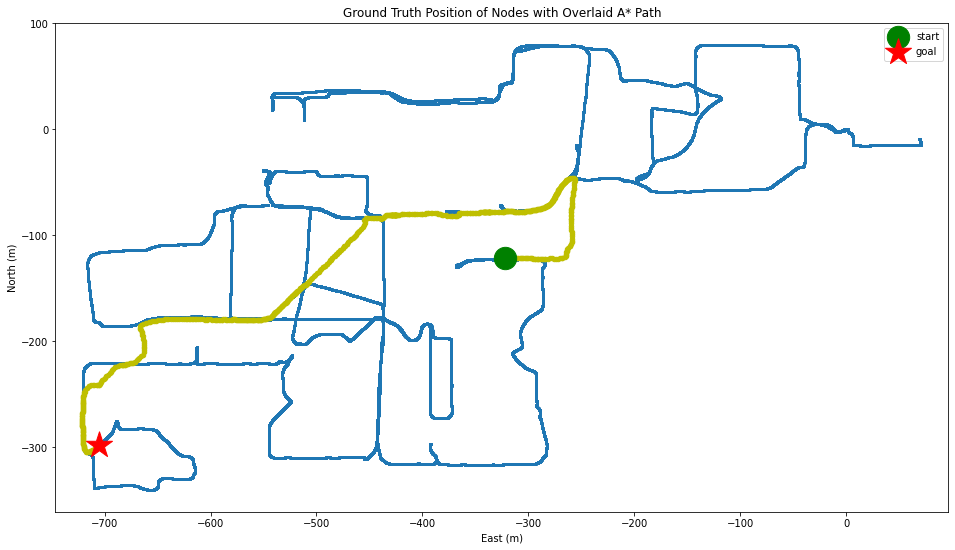

In [0]:
#Plot computed path
plt.figure(figsize=(16,9))
plt.scatter(poses[:,1], poses[:,0], s=1)
plt.scatter(poses[path,1], poses[path,0], c='y', s=20)
plt.scatter(poses[start_idx,1], poses[start_idx,0], marker='o', c='g', s=500, label='start')
plt.scatter(poses[goal_idx,1], poses[goal_idx,0], marker='*', c='r', s=750, label='goal')
plt.legend()
plt.title('Ground Truth Position of Nodes with Overlaid A* Path')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.axis('equal')

In [0]:
#SE(2) functions
def matrix_log_SO2(SO2_mat) :
  #ln(R) in SO(3) = theta
  return np.arctan2(SO2_mat[1,0], SO2_mat[0, 0])

def matrix_log_SE2(SE2_mat) :
  theta = matrix_log_SO2(SE2_mat[0:2, 0:2])
  if (theta < 1e-6) :
    A = 1
    B = 0
  else :
    A = np.sin(theta)/theta
    B = (1-np.cos(theta))/theta

  v_inv = 1/(A**2 + B**2) * np.array([[A, B], [-B, A]])
  mat_log = np.array(np.matmul(v_inv, SE2_mat[0:2, 2]))
  mat_log = np.append(mat_log, theta)

  return mat_log

def matrix_exp_so2(theta) :
  #reconstruct R.
  return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

def matrix_exp_se2(twist) :
  theta = twist[-1]
  R = matrix_exp_so2(theta)
  
  #V converges to I2
  if (theta < 1e-6) :
    V = np.eye(2)
  else:
    V = 1/theta * np.array([[np.sin(theta), -(1 - np.cos(theta))], [(1-np.cos(theta)), np.sin(theta)]])

  mat_exp = np.zeros((3,3))
  mat_exp[0:2, 0:2] = R
  mat_exp[0:2, 2] = np.matmul(V, twist[0:2])
  mat_exp[2, 2] = 1
  
  return mat_exp

def get_twist_SE2(Xstart, pos_end, pos_future=None) :
  
  Xend = np.zeros((3,3))
  
  Xend[-1,-1] = 1
  Xend[0:2, 2] = pos_end
  
  #compute end direction (face in direction of future step i.e. end+1)
  if not pos_future is None:
    next_displacement = pos_future - pos_end
    next_theta = np.arctan2(next_displacement[1], next_displacement[0])
    Xend[0:2, 0:2] = np.array([[np.cos(next_theta), -np.sin(next_theta)], [np.sin(next_theta), np.cos(next_theta)]])
  else :
    Xend[0:2, 0:2] = Xstart[0:2, 0:2]

  # set_trace()
  twist_SE2 = matrix_log_SE2(np.matmul(np.linalg.inv(Xstart), Xend))

  return twist_SE2, Xend

def twist_motion(Xstart, twist, s=1) :
  return np.matmul(Xstart, s * matrix_exp_se2(twist))

In [0]:
print('testing exponential map for SE2')
thetas = [0, 1e-4, np.pi/2, np.pi, 15*np.pi/8, 4.5 * np.pi]

for theta in thetas :
  test_SE2 = np.array([[np.cos(theta), -np.sin(theta), 1.5], [np.sin(theta), np.cos(theta), 2], [0, 0, 1]])
  
  twist = matrix_log_SE2(test_SE2)
  SE2_res = matrix_exp_se2(twist)
  
  assert(np.sum(test_SE2 - SE2_res) < 1e-6)
  print('passed theta = ', theta)

testing exponential map for SE2
passed theta =  0
passed theta =  0.0001
passed theta =  1.5707963267948966
passed theta =  3.141592653589793
passed theta =  5.890486225480862
passed theta =  14.137166941154069


In [359]:
#Generation of twists and executing path
print('testing motion twist generation')

pos_end = np.array([x1, y1])
pos_future = np.array([x2, y2])

twists = []

Xstart = np.eye(3)
Xstart[0:2, 2] = poses[path[0]]

poses = np.array(poses)

for pose_idx, path_idx in enumerate(path[1:-1]) :
  twist, Xstart = get_twist_SE2(Xstart, poses[pose_idx], poses[path_idx + 1])
  twists.append(twist)
  #print(twist)

twist, Xend = get_twist_SE2(Xstart, poses[-1])
twists.append(twist)


Xk = np.eye(3)
Xk[0:2, 2] = poses[path[0]]

for twist in twists :
  Xk = twist_motion(Xk, twist)

assert(np.sum(Xk - Xend) < 1e-6)
print('passed')

testing motion twist generation
passed


[[0.         0.        ]
 [0.06225802 0.4961088 ]
 [0.09777187 0.74359323]
 ...
 [0.61079301 0.79024087]
 [0.64382541 0.76317733]
 [0.         0.        ]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


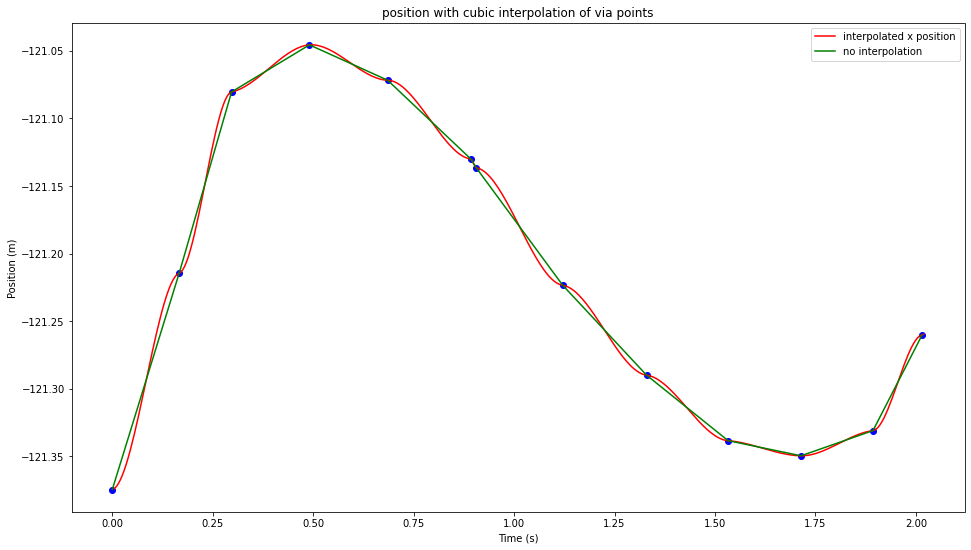

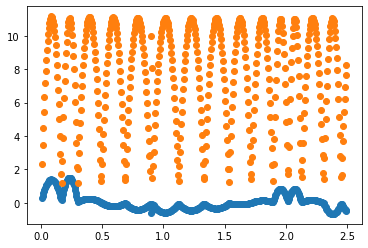

In [0]:
#Cubic interpolation of poses.

poss = np.array(poses[path])
velocities = np.zeros(poss.shape) 
T = np.zeros(poss.shape[0])

total_time = 100
total_dist = total_dist_fun(poss)
cum_dist = 0

velocities[0] = 0

for i in range(1, poss.shape[0] - 1) :
  seg_dist = np.linalg.norm(poss[i+1] - poss[i])
  velocities[i] = (((poss[i+1] - poss[i]) / seg_dist) + velocities[i-1])/2
  T[i] = total_time * cum_dist/total_dist
  cum_dist += seg_dist
  
T[-1] = total_time
velocities[-1] = 0
print(velocities)

a = np.zeros((poss.shape[0], 4, poss.shape[1]))

for j in range(0, poss.shape[0]-1) :
  del_Tj = T[j+1] - T[j]
  a[j, 0] = poss[j]
  a[j, 1] = velocities[j]
  a[j, 2] = (3 * poss[j+1] - 3 * poss[j] - 2 * velocities[j] * del_Tj - velocities[j+1] * del_Tj)/ (del_Tj**2)
  a[j, 3] = (2 * poss[j] + (velocities[j] + velocities[j+1]) * del_Tj - 2 * poss[j + 1]) / (del_Tj**3)

del_t = 0.005
pos_x = [a[0,0][0]]
pos_y = [a[0,0][1]]
vel_x = [0]
vel_y = [0]

total_trial = 100

for t in np.arange(del_t, total_trial, del_t) :
  j = np.argmax(T > t)-1
  delta_t = t - T[j]
  pos_t = a[j, 0] + a[j, 1]* delta_t + a[j, 2] * (delta_t**2) + a[j, 3] * (delta_t**3)
  pos_x.append(pos_t[0])
  pos_y.append(pos_t[1])
  vel_x.append((pos_x[-1] - pos_x[-2])/del_t)
  vel_y.append((pos_y[-1] - pos_y[-2])/del_t)

t = np.arange(0, total_trial, del_t)

plt.figure(figsize=(16,9))
plt.plot(t[1:405], pos_x[1:405], linestyle='-', c='r', label='interpolated x position')
# plt.scatter(t[0:400], pos_y[0:400], label='y position')

plt.scatter(T[1:14], poss[1:14,0], c='b')
plt.plot(T[1:14], poss[1:14,0], linestyle='-', c='g', label='no interpolation')
# plt.scatter(T[0:10], poss[0:10,1], label='y no interp')

plt.legend()
plt.title('position with cubic interpolation of via points')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')


plt.figure()
plt.scatter(t[2:500], vel_x[2:500])
plt.scatter(t[2:500], vel_y[2:500])